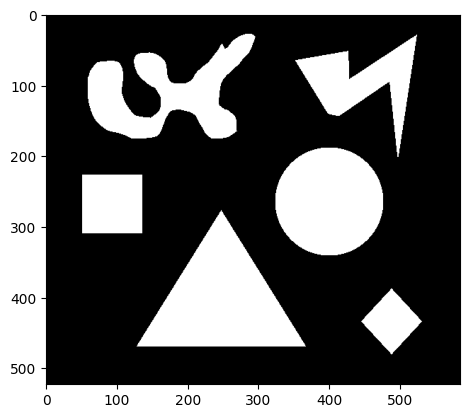

In [2]:
# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
import matplotlib.pyplot as plt
import cv2
import numpy as np
img = cv2.imread('./figuras.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(img_gray,0,1,cv2.THRESH_OTSU)

plt.imshow(mask, cmap='gray')
plt.show()

número de objetos:  6
posibles valores de intensidad:  [0 1 2 3 4 5 6]
4


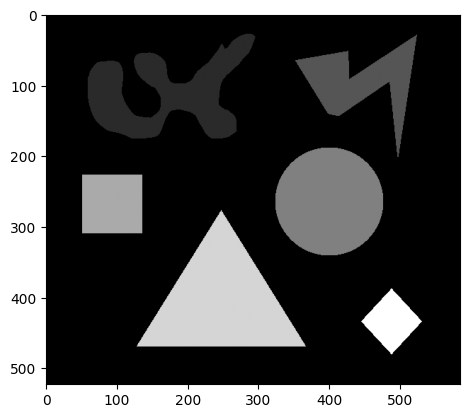

In [8]:
# Convertimos la imagen binaria en una imagen de etiquetas para tener acceso a cada objeto por separado
from skimage.measure import label

lab, num = label(mask, return_num=True)

# Importante:
# En 'num' devuelve 6 valores correspondientes a los 6 objetos que hay en la imagen.
# Sin embargo, 'lab' contiene hasta 7 valores diferentes, ya que también tiene en cuenta el fondo de la imagen.
print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)

print(lab[250,100])
plt.imshow(lab, cmap='gray')
# The cmap='gray' will map the lowest value in the picture (0) to black, and the highest value in the picture (6) to white.
# that way, we see different gray scales

plt.show()

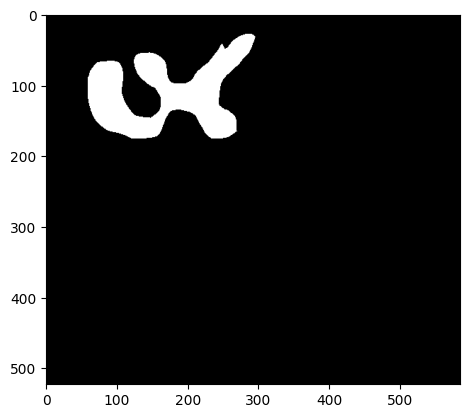

In [9]:
# Podemos acceder de manera independiente al objeto que nos interese a partir de su etiqueta correspondiente
objeto = lab == 1
objeto = objeto.astype('uint8')
plt.imshow(objeto, cmap='gray')
plt.show()

(28, 59, 176, 296)


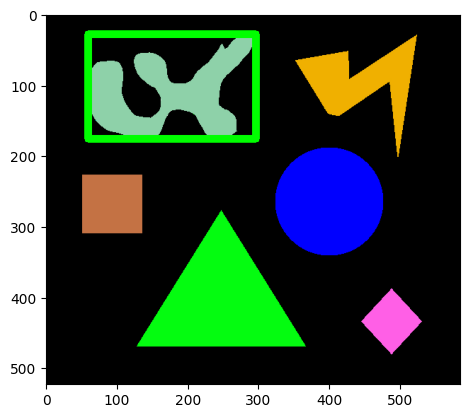

In [10]:
from skimage.measure import regionprops
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

# Después, podemos extraer la bounding box de dicho objeto
prop = regionprops(objeto)
bbox = prop[0].bbox
print(bbox)
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(img.copy(), start_point, end_point, (0, 255, 0), 10)

plt.imshow(window, cmap='gray')
plt.show()

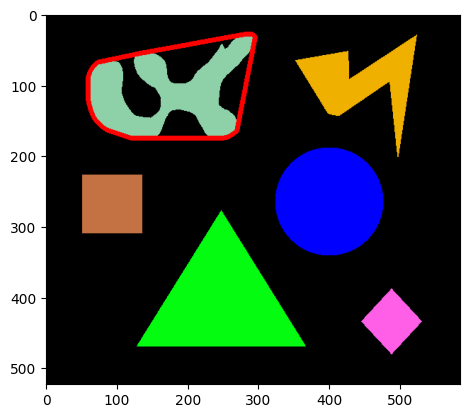

In [11]:
# Y la convex hull image
from skimage.morphology import convex_hull_image

convex_image = convex_hull_image(objeto)
convex_image = convex_image.astype('uint8')
# plt.imshow(convex_image, cmap='gray')
# plt.show()

conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Encontramos los contornos en una máscara
imagen = cv2.drawContours(img.copy(), conts, -1, (255,0,0), 5) # Dibujamos los contornos

plt.imshow(imagen, cmap='gray')
plt.show()

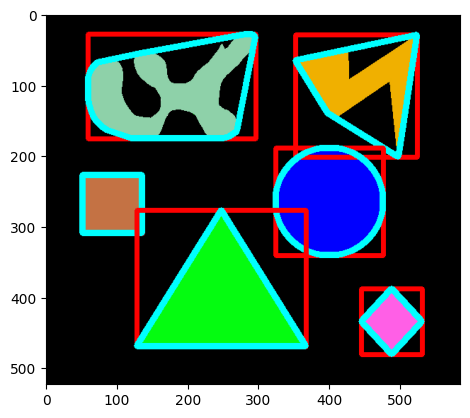

In [12]:
# Repetimos el proceso completo para todos los objetos de la imagen
imagen = img.copy()
for i in range(1, num+1):
    objeto = lab == i
    objeto = objeto.astype('uint8')

    # bbox
    prop = regionprops(objeto)
    bbox = prop[0].bbox
    imagen = cv2.rectangle(imagen, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 5)

    # covex hull
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,255), 8)

plt.imshow(imagen, cmap='gray')
plt.show()

In [13]:
# Vamos a extraer diferentes descriptores geométricos que nos ayudarán a caracterizar los objetos.
# pip install tabulate
from tabulate import tabulate
import math

new_lab, new_num = label(mask, return_num=True)

# Extraemos las característicias geométricas
headers = ['','Raro', 'Rayo', 'Círculo', 'Cuadrado', 'Triángulo', 'Rombo']
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))

    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    OR.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))

                      Raro        Rayo     Círculo    Cuadrado    Triángulo      Rombo
--------------  ----------  ----------  ----------  ----------  -----------  ---------
area            16198       10282       18344        7055        23119       4018
bbox_area       35076       29756       23104        7055        46127       7998
convex_area     27405       16959       18488        7055        23307       4102
eccentricity        0.8556      0.7941      0           0.2157       0.371      0.3866
equiv_diameter    143.61      114.418     152.828      94.7771     171.569     71.5254
extent              0.4618      0.3455      0.794       1            0.5012     0.5024
major_axis        268.45      186.995     152.828      98.1428     195.774     76.1969
minor_axis        138.975     113.644     152.828      95.8332     181.801     70.2735
orientation        -1.4236      1.5298     -0.7854      1.5708      -1.5708     0
perimeter        1029.77      736.02      503.245     332      